In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

In [2]:
# Load data
job_postings = pd.read_csv("job_postings.csv")
job_skills = pd.read_csv("job_skills.csv")
job_summary = pd.read_csv("job_summary.csv")

In [3]:
# Data Cleaning
job_postings.drop_duplicates(inplace=True)
job_skills.drop_duplicates(inplace=True)
job_summary.drop_duplicates(inplace=True)
job_skills["job_skills"].fillna("Unknown", inplace=True)
job_postings["job_location"].fillna("Unknown", inplace=True)

C:\Users\Disha Nayak\AppData\Local\Temp\ipykernel_17560\2005538630.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  job_skills["job_skills"].fillna("Unknown", inplace=True)
C:\Users\Disha Nayak\AppData\Local\Temp\ipykernel_17560\2005538630.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [4]:
# Normalize text columns
for col in ["job_title", "company"]:
    job_postings[col] = job_postings[col].str.lower().str.strip()
job_skills["job_skills"] = job_skills["job_skills"].str.lower().str.strip()
job_summary["job_summary"] = job_summary["job_summary"].str.lower().str.strip()

In [5]:
# Merge data
df = job_postings.merge(job_skills, on="job_link", how="inner").merge(job_summary, on="job_link", how="inner")

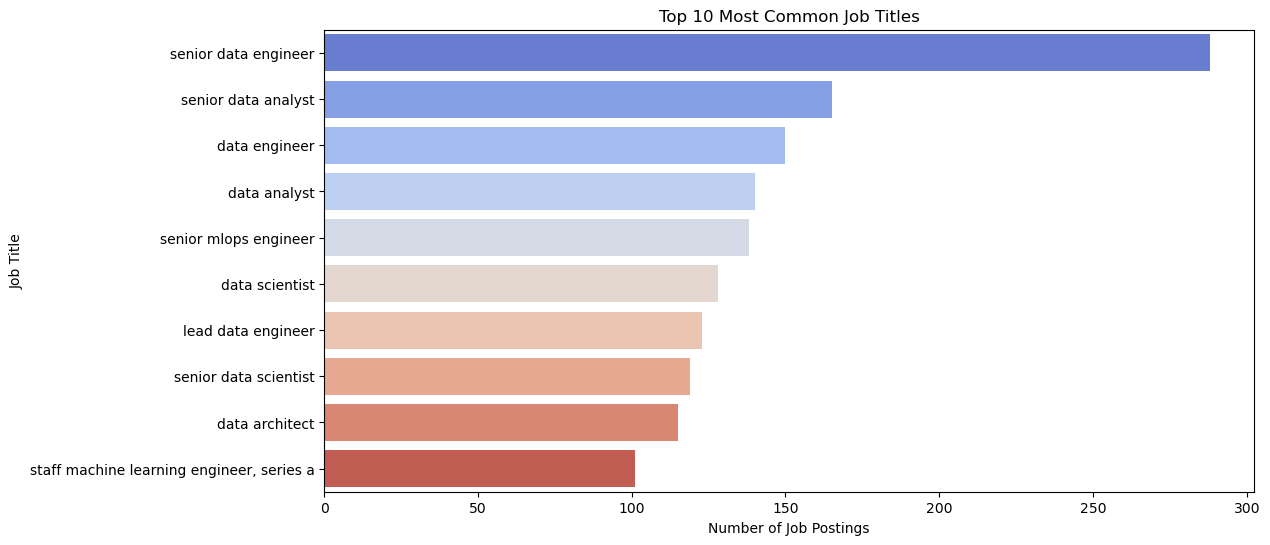

In [8]:
# Data Visualization
plt.figure(figsize=(12, 6))
top_jobs = df["job_title"].value_counts().head(10)
sns.barplot(y=top_jobs.index, x=top_jobs.values, palette="coolwarm",hue=top_jobs.index,legend=False)
plt.title("Top 10 Most Common Job Titles")
plt.xlabel("Number of Job Postings")
plt.ylabel("Job Title")
plt.show()

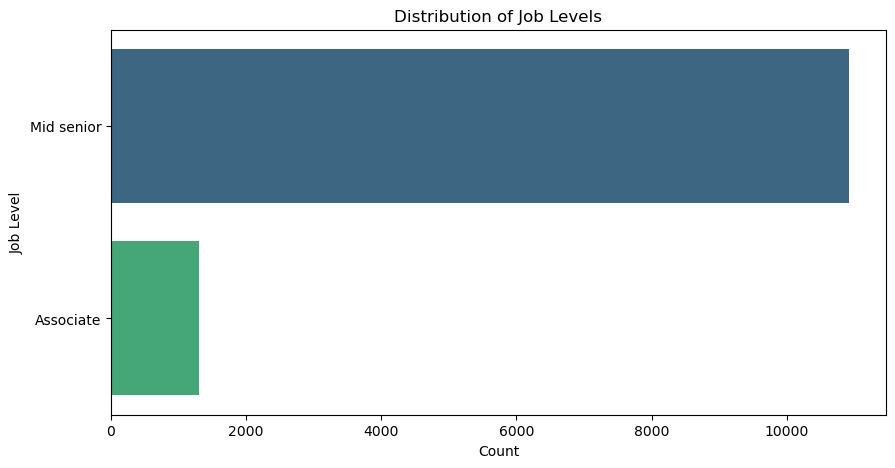

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(y=df["job_level"], order=df["job_level"].value_counts().index,hue=df["job_level"],palette="viridis",legend=False)
plt.title("Distribution of Job Levels")
plt.xlabel("Count")
plt.ylabel("Job Level")
plt.show()


In [10]:
from collections import Counter

# Combine all skills into a single list
all_skills = ", ".join(df["job_skills"]).split(", ")

# Count occurrences of each skill
skill_counts = Counter(all_skills)

# Convert to DataFrame
skill_df = pd.DataFrame(skill_counts.items(), columns=["Skill", "Count"]).sort_values(by="Count", ascending=False)

# Display top skills
skill_df.head(10)


,Skill,Count
2,python,4810
65,sql,4610
62,data analysis,3293
0,machine learning,2684
64,communication,2506
15,data visualization,2330
291,aws,1740
103,project management,1737
5,data engineering,1714
46,communication skills,1712


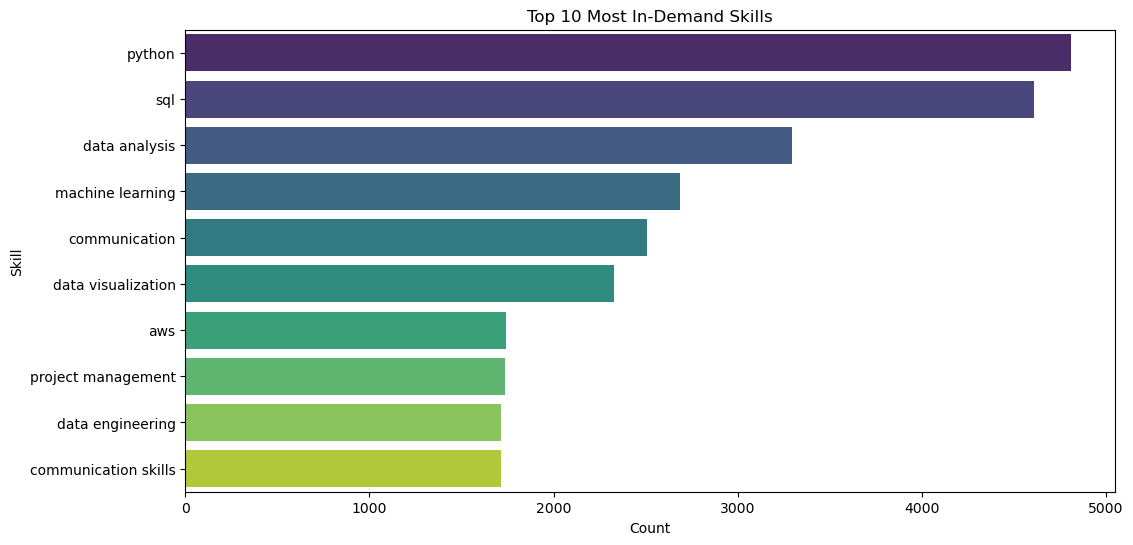

In [11]:

plt.figure(figsize=(12, 6))
sns.barplot(y=skill_df["Skill"][:10], x=skill_df["Count"][:10], palette="viridis",hue=skill_df["Skill"][:10],legend=False)
plt.title("Top 10 Most In-Demand Skills")
plt.xlabel("Count")
plt.ylabel("Skill")
plt.show()


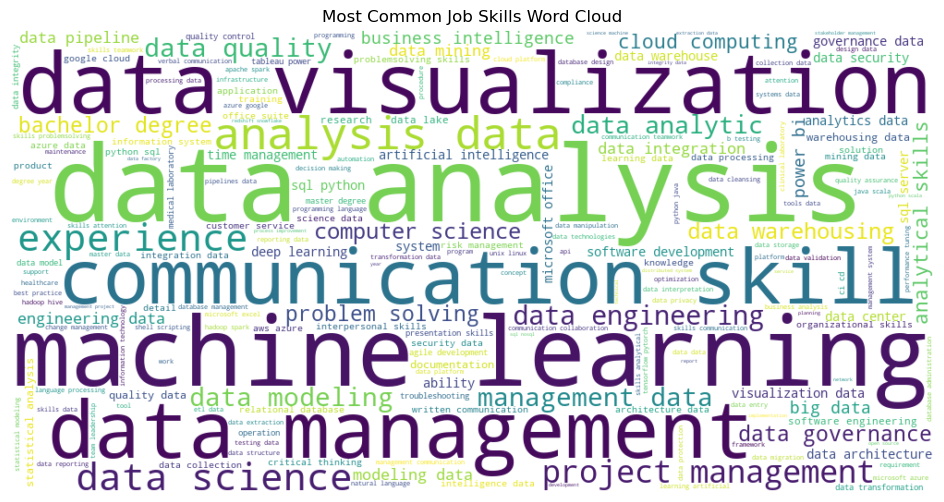

In [12]:
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(", ".join(df["job_skills"].dropna()))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Job Skills Word Cloud")
plt.show()




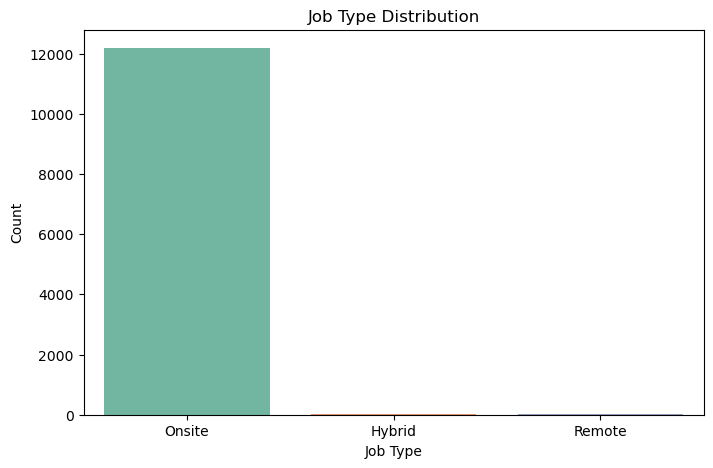

In [13]:

plt.figure(figsize=(8, 5))
sns.countplot(x=df["job_type"], hue=df["job_type"], palette="Set2", legend=False)
plt.title("Job Type Distribution")
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.show()


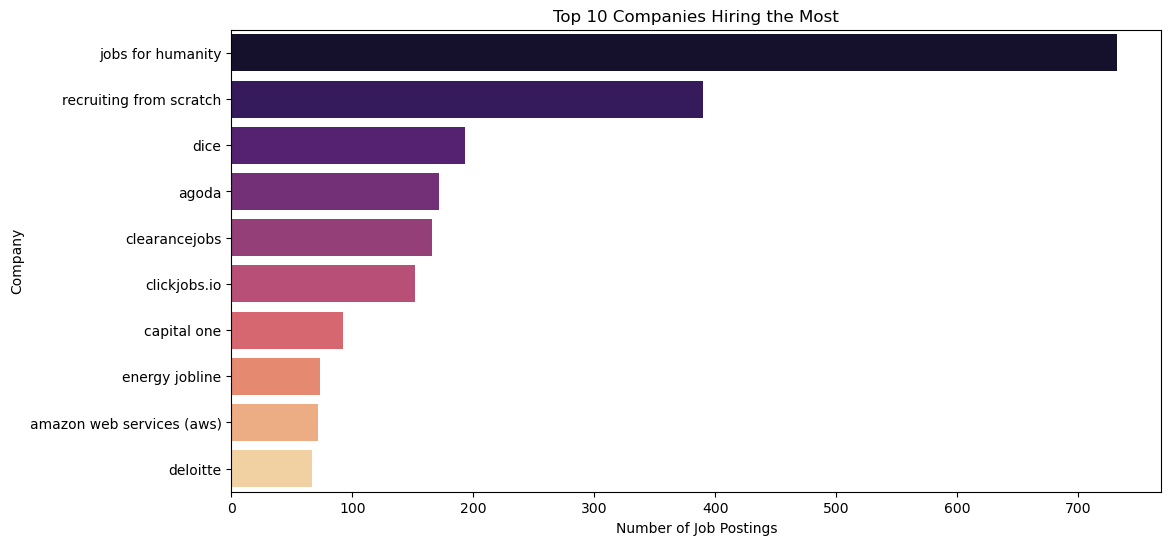

In [14]:
plt.figure(figsize=(12, 6))
top_companies = df["company"].value_counts().head(10)  # Top 10 hiring companies

sns.barplot(y=top_companies.index, x=top_companies.values, palette="magma",hue=top_companies.index, legend=False)
plt.title("Top 10 Companies Hiring the Most")
plt.xlabel("Number of Job Postings")
plt.ylabel("Company")
plt.show()


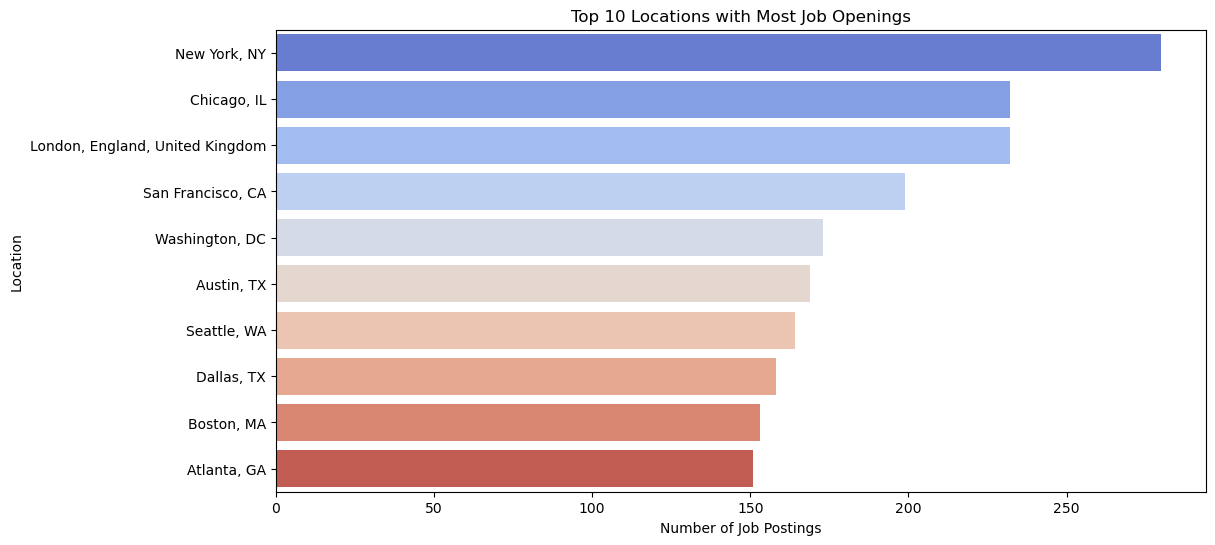

In [15]:
plt.figure(figsize=(12, 6))
top_locations = df["job_location"].value_counts().head(10)  # Top 10 locations

sns.barplot(y=top_locations.index, x=top_locations.values, palette="coolwarm",hue=top_locations.index,legend=False)
plt.title("Top 10 Locations with Most Job Openings")
plt.xlabel("Number of Job Postings")
plt.ylabel("Location")
plt.show()


In [16]:
# Categorize job titles
def categorize_job_title(title):
    title = title.lower()
    categories = {
        "data science & ai": ["data scientist", "machine learning", "ai"],
        "software development": ["software engineer", "developer", "backend", "frontend"],
        "data & business analytics": ["business analyst", "data analyst", "analytics"],
        "cloud & devops": ["cloud", "devops"],
        "cybersecurity": ["cybersecurity", "security"],
        "product & project management": ["product manager", "project manager"]
    }
    for category, keywords in categories.items():
        if any(kw in title for kw in keywords):
            return category
    return "other"

df["career_path"] = df["job_title"].apply(categorize_job_title)

In [17]:
# Encode categorical features
career_path_encoder = LabelEncoder()
df["career_path_encoded"] = career_path_encoder.fit_transform(df["career_path"])
job_level_encoder = LabelEncoder()
df["job_level_encoded"] = job_level_encoder.fit_transform(df["job_level"])

In [30]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
skills_tfidf = vectorizer.fit_transform(df["job_skills"])
skills_df = pd.DataFrame(skills_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

df_model = pd.concat([df, skills_df], axis=1)
df_model.drop(columns=["job_link", "job_skills", "career_path", "job_level", "last_processed_time", "last_status", "got_summary", "got_ner"], errors="ignore", inplace=True)


In [33]:
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
print(f"Non-numeric columns: {non_numeric_cols.tolist()}")
X = df_model.drop(columns=non_numeric_cols, errors="ignore")
y = df_model["career_path_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Non-numeric columns: ['is_being_worked', 'job_title', 'company', 'job_location', 'first_seen', 'search_city', 'search_country', 'search_position', 'job_type', 'job_summary']


In [34]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

In [35]:
# Evaluate model
y_pred = best_model.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f"\U0001F50D Optimized Model Accuracy: {accuracy:.2f}")


🔍 Optimized Model Accuracy: 0.94


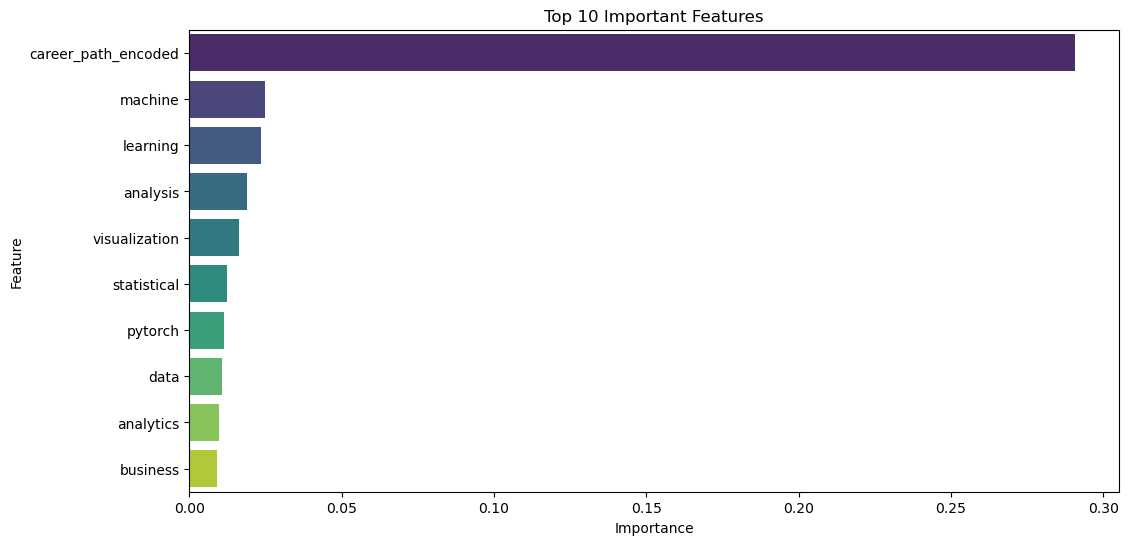

In [37]:
# Feature Importance
importances = best_model.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df["Importance"][:10], y=importance_df["Feature"][:10], palette="viridis",hue=importance_df["Feature"][:10],legend=False)
plt.title("Top 10 Important Features")
plt.show()

In [66]:
# Career Path Suggestion
def find_skill_gaps(user_skills, target_job):
    # Limit skill gaps to top 5
    job_skills = df[df["career_path"] == target_job]["job_skills"].str.split(", ")
    all_required_skills = set(skill for skills in job_skills.dropna() for skill in skills)
    missing_skills = list(all_required_skills - set(user_skills))
    return missing_skills[:5]  # Return only the top 5 skill gaps
    job_skills = df[df["career_path"] == target_job]["job_skills"].str.split(", ")
    all_required_skills = set(skill for skills in job_skills.dropna() for skill in skills)
    missing_skills = all_required_skills - set(user_skills)
    return list(missing_skills)

def get_salary_estimate(career_path):
    salary_data = {
        "data science & ai": "₹10L-₹15L",
        "software development": "₹8L-₹12L",
        "data & business analytics": "₹8.5L-₹13L",
        "cloud & devops": "₹9L-₹14L",
        "cybersecurity": "₹9.5L-₹14.5L",
        "product & project management": "₹11L-₹16L"
    }
    return salary_data.get(career_path, "Salary data not available")

def get_recommended_courses(skill_gaps):
    course_data = {
        "deep learning": "Deep Learning Specialization - Coursera",
        "big data": "Big Data with Spark - Udemy",
        "nlp": "NLP with Python - edX",
        "aws": "AWS Certified Solutions Architect - Udemy",
        "tensorflow": "TensorFlow for AI - Coursera",
        "sql": "SQL for Data Science - Udemy",
        "python": "Python for Everybody - Coursera",
        "machine learning": "Machine Learning - Coursera"
    }
    return [course_data.get(skill.lower(), f"Explore {skill} on Udemy or Coursera") for skill in skill_gaps[:3]]
    course_data = {
        "deep learning": "Deep Learning Specialization - Coursera",
        "big data": "Big Data with Spark - Udemy",
        "nlp": "NLP with Python - edX",
        "aws": "AWS Certified Solutions Architect - Udemy",
        "tensorflow": "TensorFlow for AI - Coursera"
    }
    return [course_data.get(skill, "General AI Course - Udemy") for skill in skill_gaps[:3]]

def suggest_career_with_growth(candidate_skills, candidate_level):
    career_path = suggest_career(candidate_skills, candidate_level)
    skill_gaps = find_skill_gaps(candidate_skills, career_path)
    salary_estimate = get_salary_estimate(career_path)
    recommended_courses = get_recommended_courses(skill_gaps)
    return {
        "career_path": career_path,
        "recommended_courses": recommended_courses,
        "skill_gaps": skill_gaps,
        "salary_estimate": salary_estimate
    }

In [67]:
def suggest_career(candidate_skills, candidate_level):
    candidate_tfidf = vectorizer.transform([" ".join(candidate_skills)]).toarray()
    candidate_tfidf_df = pd.DataFrame(candidate_tfidf, columns=vectorizer.get_feature_names_out())  # Keep feature names
    
    candidate_level_encoded = job_level_encoder.transform([candidate_level])[0]
    candidate_level_df = pd.DataFrame([[candidate_level_encoded]], columns=["job_level_encoded"])  # Keep feature name
    
    candidate_input = pd.concat([candidate_tfidf_df, candidate_level_df], axis=1)  # Combine into DataFrame
    candidate_level_encoded = job_level_encoder.transform([candidate_level])[0]
    candidate_input = np.hstack([candidate_tfidf, [[candidate_level_encoded]]])
    predicted_career_encoded = best_model.predict(candidate_input)[0]
    return career_path_encoder.inverse_transform([predicted_career_encoded])[0]

In [68]:
candidate_skills = ["python", "machine learning", "sql"]
candidate_level = "Mid senior"
career_growth_info = suggest_career_with_growth(candidate_skills, candidate_level)

print(f"🔍 Suggested Career Path: {career_growth_info['career_path']}")
print(f"⚡ Skill Gaps: {career_growth_info['skill_gaps']}")
print(f"🎓 Recommended Courses: {career_growth_info['recommended_courses']}")
print(f"💰 Estimated Salary Range: {career_growth_info['salary_estimate']}")



🔍 Suggested Career Path: data & business analytics
⚡ Skill Gaps: ['snowflake certifications', 'iseb ba diploma', 'demonstrative graphics', 'database design development', 'basic code of conduct guidelines']
🎓 Recommended Courses: ['Explore snowflake certifications on Udemy or Coursera', 'Explore iseb ba diploma on Udemy or Coursera', 'Explore demonstrative graphics on Udemy or Coursera']
💰 Estimated Salary Range: ₹8.5L-₹13L


C:\Users\Disha Nayak\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
